트랜스포머에 대해서 더 깊게 이해해보고 싶어서 코드를 구현하면서 공부하는 노트입니다.

모든 코드는 https://wikidocs.net/31379 에서 가져왔습니다. 

트랜스포머에는 d_model, num_layers, num_heads, d_ff 라는 주요 하이퍼 파라미터가 있다.

- d_model: 모델의 인코더와 디코더에서 입력과 출력의 크기. 임베딩벡터의 차원이다.

- num_layers: 인코더와 디코더의 구성 층 개수

- num_heads: 어텐션을 사용할 때, 한 번하는 것 보다 여러개로 분할해서 병렬로 어텐션을 수행하고 결과값을 합치는 방식을 사용. 병렬의 개수

- d_ff: 피드 포워드 신경망에서의 은닉층 크기. 피드 포워드 신경망의 입력과 출력의 크기는 d_model 이다. 

트랜스포머는 RNN과 다르게 순차적으로 데이터가 입력되지 않기 때문에 positional encoding을 통해서 데이터의 순서를 알려주어야 한다. 

일단 그거는 미뤄두고 어텐션 부터 공부하겠음.

Transfomer은 self-Attention을 사용하는데 이건 Q,K,V가 모두 같은 것이다. 즉, 데이터 스스로 Q를 보내면 데이터가 Key와 Value를 찾는 것이다. 

Q, K, V가 좀 헷갈린다. 이게 뭐냐면 Q(쿼리)를 요청해서 K(key)로 V(value)를 얻는 과정이다.

그러니까 트랜스포머에서는 Q에 대한 어텐션점수(V)를 구해주세요~ 하면 K(key)를 통해서 V(어텐션 점수)를 구하는 거다.

원래 어텐션의 과정은 아래 그림과 같다.

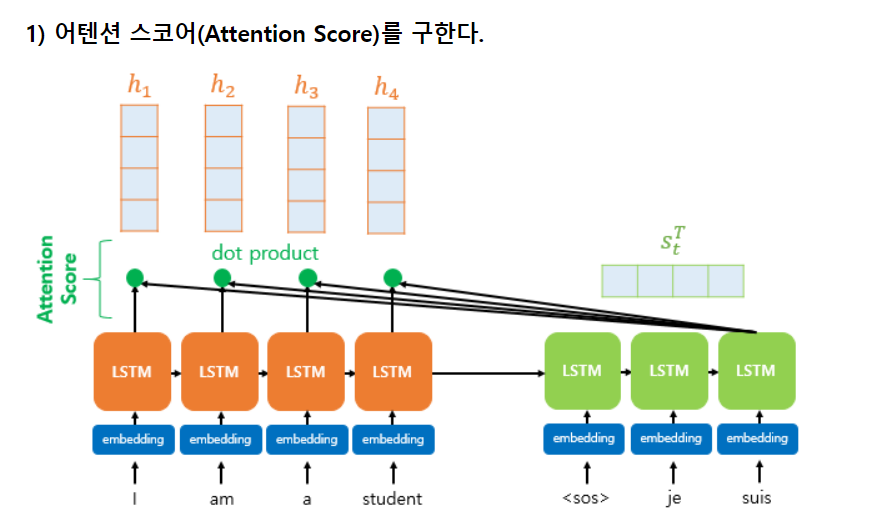

위와 같이 인코더의 은닉층에 디코더의 벡터를 내적해서 유사도를 구한다.  

행렬 내적을 하면 유사도를 구할 수 있다는건 이제 알고 있다 ㅋ

트랜스포머에서 셀프 어텐션은 입력 문장의 단어 벡터들을 가지고 수행한다고 했는데, 사실 셀프 어텐션은 인코더의 초기입력인 d_model 차원을 가지는 단어 벡터들을 사용해서 셀프 어텐션을 수행하는 것이 아니라 우선 각 단어 벡터들로부터 Q벡터, K벡터, V벡터를 얻는 작업을 거친다. 이때 Q벡터, K벡터, V벡터는 초기 입력인 d_model/ num_heads로 나눈 값을 차원으로 가진다.

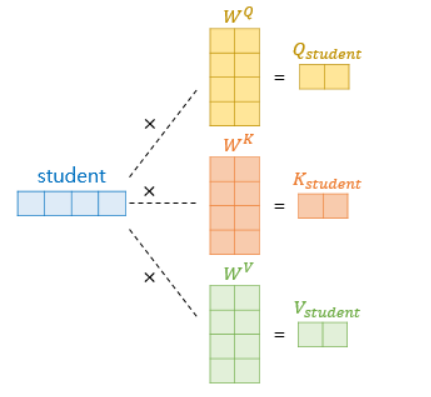

위는 예시 그림이다. 

또한 어텐션은 Scaled dot-product attention을 사용한다. 이거는 기존의 Attention score를 sqrt(입력벡터의 차원)으로 나누어준 값이다.

그 다음 과정으로는 Scaled dot attention을 사용한 값을 softmax 함수에 넣고, 얻은 값을 각 V벡터와 가중합 해서 최종적인 Attention value를 구한다. 아래는 예시 그림이다. 

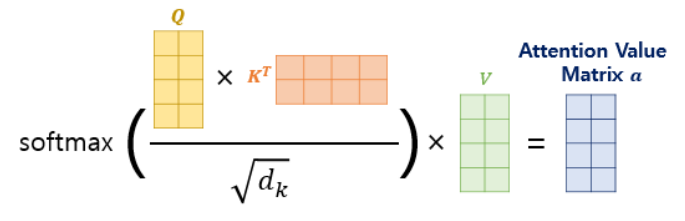

#### 여기서 드는 의문
1. 가중치의 초기 상태는 어떻게 정해질까?
wieght initialization이라는 분야에서 전문적으로 다루는 듯하다. 잠깐 봤는데 양이 한사바리다. 일단 <b>PASS</b>
2. 왜 Scaled dot-product를 해야할까? 
Q와 K의 길이가 커질 수록 내적값 역시 커질 가능성이 높아진다고 한다. 여기서 문제가 발생하는데 이렇게 되면 softmax의 기울기가 0인 영역에 도달하기 쉬워진다. 즉, gradient vanishing이 일어나게 되는것이다. 그렇기 때문에 scale을 해주면 이런 문제가 해결 될 수 있다.

왜 차원이 길어질수록 softmax의 기울기가 0인 영역에 도달하기 쉬울까?? 

-> q_i와 k_i가 i.i.d N(0,1)분포를 따를 때, E(q_\i * k_\i) = 0, Var(q_i * k_i)=0 이다. <br>
그렇게 되면 sum(i=1~dk)q_i*k_i ~ N(0,d_k) 분포를 따른다. 하지만 스케일링을 해주면 N(0,1)을 따르기 때문에 gradient vanishing 문제를 완화할 수 있다.

In [7]:
import tensorflow as tf

def scaled_dot_product_attention(Q, K, V, mask):
    # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    # padding_mask : (batch_size, 1, 1, key의 문장 길이)

    # Q와 K의 내적을 구한다.
    matmul_qk = tf.matmul(Q,K,transpose_b=True)

    # 스케일링
    depth = tf.cast(tf.shape(K)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 마스킹 
    # 이거는 아래서 배운당
    if mask is not None:
        logits += (mask * -1e9)
    
    # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
    # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)

    # 나는 아래 axis=-1을 Q*K.T 니까 결국 K의 행 길이로 이루어 진다고 생각했다. 
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    output = tf.matmul(attention_weights, V)

    return output, attention_weights

와우 위에 코드를 이해하면서 작성했다. 굉장히 뿌듯함. ㅋㅋㅋㅋ 재밌당

In [8]:
import numpy as np

np.set_printoptions(suppress=True)
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

# 함수 실행
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn) # 어텐션 분포(어텐션 가중치의 나열)
print(temp_out) # 어텐션 값

tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


### 멀티 헤드 어텐션
위에 코드는 입력벡터를 d_model 차원이 아니라 낮춰서 어텐션을 진행했다. 

왜 그러냐면, d_model 차원으로 어텐션을 한번 진행하는 것보다 d_model/num_heads 차원으로 num_heads 번 진행하는게 효율적이라고 연구자들이 판단했기 떄문이다. 나도 그렇게 생각한다. 오케이 굳

그러면 병렬적으로 self-attention을 진행하고 concat 해주면 된다. 그러면 최종적인 차원이 (seq_len, d_model)이 된다.

마지막으로 (d_model, d_model)차원인 W_O를 곱한다. 

마지막에 W_O를 곱하는 이유는 아래와 같다. (G모씨의 고마운 조언이 있었다).

------

이렇게 concat 후 내적하는 이유는, 각 헤드에서 얻은 어텐션 값들은 서로 다른 측면(aspect)에서 정보를 추출하기 때문입니다. 예를 들어, 어텐션 메커니즘을 사용하여 번역을 수행하는 경우, 각 헤드는 다른 단어의 중요도를 파악하거나, 다른 문법적인 특성을 추출할 수 있습니다. 따라서, 이러한 서로 다른 측면에서 얻은 정보들을 합쳐 최종 출력 값을 계산함으로써 보다 정확하고 풍부한 정보를 반영할 수 있습니다.

그리고 이 때 w^O를 사용하여 다시 내적(dot product)하는 이유는, 최종 출력 값의 차원을 원하는 차원으로 맞추기 위해서입니다. 즉, concat된 벡터와 가중치 행렬을 내적하면, 최종 출력 값의 차원은 가중치 행렬의 열의 수와 같아지게 됩니다. 이를 통해, 최종 출력 값을 원하는 차원으로 조정할 수 있습니다.

### 멀티 헤드 어텐션 구현 (여기까지함)

In [8]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__ (self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name) # 이 부분 코드 뭐지...? 상속 다시 공부하쟈...
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0 # assert 구문도 공부하쟈

        # 쪼개진 입력벡터의 크기
        self.depth = d_model // num_heads

        self.query_dense